# Predicting the survival of cancer cells irradiated with ionizing radiation

Alicja Krzemińska akrzeminska1519@gmail.com  
Szymon Auguścik szyauguscik@gmail.com

## Preparing to training process

### Import, creating project structure

In [ ]:
import re
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from keras import Sequential
from keras import backend as K
from keras.layers import Dense
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error

from typing import List, Dict

### Functions

#### Preprocessing data

In [ ]:
def read_dataset(filepath: str) -> pd.DataFrame:
    """
    Function reads data (containing the results of firing ions at cancer cells) from filepath
    and saves it as pandas DataFrame
    
    The idea of preparing data:
        - read whole data (including e. g. redundant header)
        - get a number of all experiments that were carried out
        - for each experiment, read header and (based on it)
          every single measurement point that was part of an experiment
        - keep a trace of current position in read lines (offset) to deal with
          different numbers of measurement points in varying experiments
    """
    
    with open(filepath) as raw_data:
        raw_lines = raw_data.readlines()
        lines = transform_raw_lines_to_lists(raw_lines)
        experiments_count = int(float(lines[1][0]))
        offset = 1
        data = []
        
        for _ in range(experiments_count):
            offset += 1
            experiment_header_line = lines[offset]
            experiment_data, offset = read_experiment_data(lines, experiment_header_line, offset)
            data += experiment_data
            
    return pd.DataFrame(data, columns=["atom_number", "beta", "dose", "mean_survivability", "min_survivability", "max_survivability", "error_of_measurement"])


def transform_raw_lines_to_lists(raw_lines: List[str]) -> List:
    """
    Function transforms all row lines from data into lists of splitted values 
    (with removing whitespaces) and returns list of these lists
    """
    
    lines = []
    
    for raw_line in raw_lines:
        line = re.split(r' ', raw_line)
        line = [number for number in line if number != '']
        lines.append(line)
        
    return lines


def read_experiment_data(lines: List, experiment_header_line: List, offset: int) -> (List, int):
    """
    Functions parses experiment coefficients into numeric types and returns measurement points
    as a tupple of list (data referring to points) and current offset
    """
    
    experiment_count = int(float(experiment_header_line[0]))
    atom_number = int(float(experiment_header_line[1]))
    beta = float(experiment_header_line[2])
    
    return read_measurement_points(experiment_count, lines, offset, atom_number, beta)


def read_measurement_points(experiment_count: int, lines: List[str], offset: int, atom_number: int, beta: float) -> (List, int):
    """
    Function collects data from measurement points, assigns valid coefficients from experiment 
    (each measurement point gets the same atom_number and beta factors) to them based on updating offset in lines.
    """
    
    measurements_data = []
    
    for _ in range(experiment_count):
        offset += 1
        line = lines[offset]
        measurement_data = read_measurement_point(line, atom_number, beta)
        measurements_data.append(measurement_data)
        
    return measurements_data, offset


def read_measurement_point(line: List, atom_number: int, beta: float) -> List:
    """
    Function reads single measurement point and returns it as a list.
    
    Meaning of consecutive numbers in list:
    atom_number, beta, dose, mean_survivability, min_survivability, max_survivability, error_of_measurement
    """
    
    return [atom_number, beta] + [float(number) for number in line]

def split_dataset_to_features_and_labels(dataset: pd.DataFrame, performShuffling: bool=False) -> (np.array, np.array):
  """
  Function gets dataset and splits it into 2 separate sets: features and labels.
  There is a possibility to perfom shuffling on a whim.
  """
  features = ['atom_number', 'beta', 'dose']
  labels = ['mean_survivability']

  X = dataset[features]
  y = dataset[labels]

  if performShuffling:
    X, y = shuffle(X, y)

  return X, y              

#### Model


In [ ]:
# probability relu for 0 - 100% values
def prelu(X: np.array) -> np.array:
  """
  Improved Rectified Linear Unit
  This function not only returns 0 when X is negative but also returns 100 when X is bigger than that
  """ 
  return K.maximum(0.0, K.minimum(X, 100.0))

def create_network_model() -> Sequential:
  """
  Function builds and compiles a simple dense regression model 
  """
  model = Sequential()

  model.add(Dense(15, input_dim=3, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation=prelu))

  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

def train_model(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array) -> Dict:
  """
  Function gets training and test/validation sets and then trains a neural network model.
  Results of training (especially coefficient of determination) are returned as a dictionary. 
  """
  model = create_network_model()
  history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0, validation_split=0.2)

  train_predictions = model.predict(X_train)
  train_R2 = r2_score(y_train, train_predictions)
  test_predictions = model.predict(X_test)
  test_R2 = r2_score(y_test, test_predictions)

  return {
            "model": model,
            "train_R2": train_R2,
            "train_predictions": train_predictions,
            "test_R2": test_R2,
            "test_predictions": test_predictions,
            "history": history
         }

#### Visualisation

In [ ]:
def plot_loss(history: Dict):
  """
  Given a result of traning (history), function plots training and validation loss over number of epochs.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = history.epoch
  labels = ['loss', 'val_loss']

  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.title("Model loss")
  plt.xlabel("Epochs [no.]")
  plt.ylabel("Mean squared error [percentage points squared]")
  plt.legend(labels)
  plt.show()

def plot_survivabilities(y_true: np.array, y_pred: np.array, r2: float, title: str):
  """
  Function plots true labels over predicted labels. In addition, it prints
  coefficient of determination and allows to set a title to plot.
  """
  plt.scatter(y_pred, y_true)
  plt.annotate(f"R2 score = {round(r2 * 100, 2)}%", (0, 100), weight='bold')
  plt.title(title)
  plt.xlabel('Predicted survivability [%]')
  plt.ylabel('True survivability [%]')
  plt.show()

def summarize_best_model(result: Dict, X_train: np.array, y_train: np.array, X_test: np. array, y_test: np.array):
  """
  Function gets crucial information about the (best) model from result and based on training and test/validation sets
  plot useful graphs (loss and survivability rate). 
  """
  model = result["model"]
  history = result["history"]
  train_R2 = result["train_R2"]
  train_predictions = model.predict(X_train)
  test_R2 = result["test_R2"] 
  test_predictions = model.predict(X_test)

  plot_loss(history)
  plot_survivabilities(y_train, train_predictions, train_R2, "Train data")
  plot_survivabilities(y_test, test_predictions, test_R2, "Test data")

def plot_element(atom_number: int, beta_value: float, data: np.array, measurements: np.array,
                 predictions: np.array, atom_name: str, beta_name: str, dose_name: str):
  """
  Function plots results of experiment carried out with beta_value and element with atom_number.
  The graph consists of measured (measurements) and predicted (predictions) survivabilities over
  dose (data). Atom_name, beta_name and dose_name are used to extract only useful informations
  from NumPy arrays.
  """
  filtered_array = data[(data[atom_name] == atom_number) & (data[beta_name] == beta_value)]
  dose_array = data[[dose_name]]
  
  x = dose_array[[index in filtered_array.index for index in data.index]].values.ravel()
  y_true = measurements[[index in filtered_array.index for index in data.index]].values.ravel()
  y_pred = predictions[[index in filtered_array.index for index in data.index]].ravel()
  
  labels = ["measured", "predicted"]

  plt.scatter(x, y_true, c='r')
  plt.scatter(x, y_pred, c='b')
  plt.title(f"Experiment of atom number = {atom_number} and beta = {beta_value}")
  plt.xlabel("Dose [Gy]")
  plt.ylabel("Survivability [%]")
  plt.legend(labels)
  plt.show()

def plot_survivabilities_for_elements(data: np.array, measurements: np.array, predictions: np.array,
                                      atom_name: str, beta_name: str, dose_name: str):
  """
  Function extracts every unique pair of atom number and beta value. Then it plots every single case (experiment)
  based on given arrays. Atom_name, beta_name and dose_name are used to extract only useful informations
  from NumPy arrays.
  """
  atoms_and_betas =  { atom: np.unique(list(beta)) for atom, beta in data.groupby(atom_name)[beta_name] } 
  
  for atom in atoms_and_betas:
    for beta in atoms_and_betas[atom]:
      plot_element(atom, beta, data, measurements, predictions, atom_name, beta_name, dose_name)

#### Summary

In [ ]:
def analyse_model(model_filename: str, dataset_filename: str, performShuffling: bool=False) -> Dict:
  """
  Function load model and dataset. There is a possibility to shuffle data before training.
  Then it fits the model with provided data and checks its performance.
  The results are returned as a dictionary.
  """
  model = load_model(model_filename)
  dataset = read_dataset(dataset_filename)
  X, y = split_dataset_to_features_and_labels(dataset, performShuffling)

  y_pred = model.predict(X)
  R2 = r2_score(y, y_pred)
  plot_survivabilities(y, y_pred, R2, "Best model")
  
  print(f"Mean squared error = {mean_squared_error(y, y_pred)}")
  
  return {
            "X": X,
            "y": y,
            "y_pred": y_pred
         }

## First look at dataset

In [ ]:
dataset = read_dataset("../data/SUR5_Train.DAT")
dataset

,atom_number,beta,dose,mean_survivability,min_survivability,max_survivability,error_of_measurement
0,1,0.50827,0.000,100.0,100.0,100.0,1.00
1,1,0.50827,0.500,68.8,60.0,75.5,8.80
2,1,0.50827,1.000,50.0,41.4,57.8,8.60
3,1,0.50827,1.500,42.8,35.1,49.6,7.69
4,1,0.50827,2.400,23.7,22.8,25.0,0.90
...,...,...,...,...,...,...,...
210,26,0.48110,0.796,23.3,20.0,27.0,3.30
211,26,0.48110,1.190,13.3,12.6,16.0,0.70
212,26,0.48110,1.600,6.0,5.7,7.1,0.30
213,26,0.48110,2.390,2.2,2.0,2.6,0.20


## Searching for the best model

In [ ]:
X, y = split_dataset_to_features_and_labels(dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=421, train_size=0.8)
best_R2 = 0.977 # best score so far
# best_result = None

for _ in range(15):
  result = train_model(X_train, y_train, X_test, y_test)
  print("--Model--")
  print(f"train_R2 = {result['train_R2']}")
  print(f"test_R2 = {result['test_R2']}")

  if result['train_R2'] < result['test_R2'] and result['test_R2'] > best_R2:
    best_R2 = result['test_R2']
    result['model'].save('best_model')
    best_result = result
    !zip -r "/content/IO_model_{round(best_R2, 3)}.zip" "/content/best_model"

--Model--
train_R2 = -0.7355969785856649
test_R2 = -0.7794469151022474
--Model--
train_R2 = 0.9656884675844171
test_R2 = 0.9723203452446124
INFO:tensorflow:Assets written to: best_model/assets
  adding: content/best_model/ (stored 0%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.index (deflated 65%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: content/best_model/saved_model.pb (deflated 88%)
  adding: content/best_model/assets/ (stored 0%)
--Model--
train_R2 = -0.7355969785856649
test_R2 = -0.7794469151022474
--Model--
train_R2 = 0.9545021028280195
test_R2 = 0.94426728647095
--Model--
train_R2 = 0.9632385544237442
test_R2 = 0.9751995869653955
INFO:tensorflow:Assets written to: best_model/assets
  adding: content/best_model/ (stored 0%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.index (deflated 65%)
  adding: content/best_mode

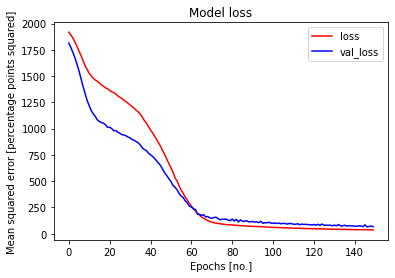

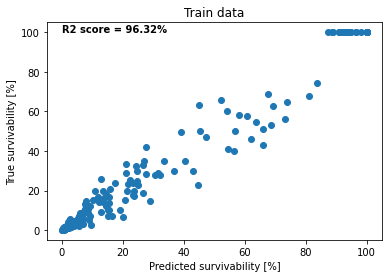

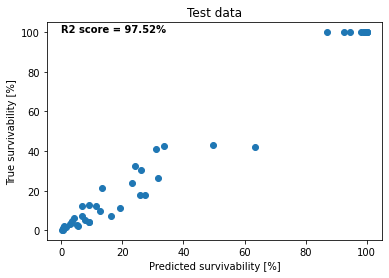

In [ ]:
if best_result is not None:
  summarize_best_model(best_result, X_train, y_train, X_test, y_test)

## Testing model

This sections allows to test our model. Due to lack of test set, we have simulated a validation on a training dataset just to show how to use our functions.

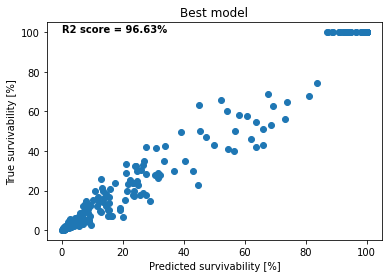

Mean squared error = 40.64436204403877


In [ ]:
# example of usage
path_to_best_model = "best_model"
path_to_test_set = "../data/SUR5_Train.DAT"
analyses_result = analyse_model(path_to_best_model, path_to_test_set, performShuffling=True)

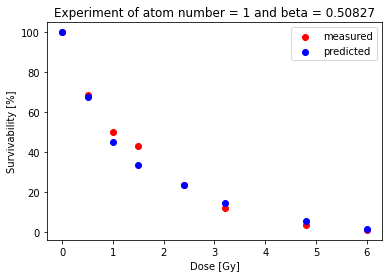

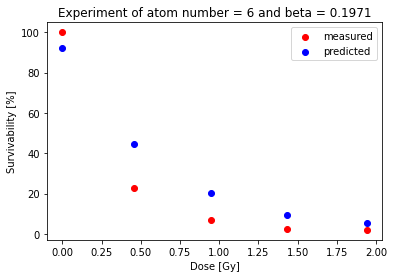

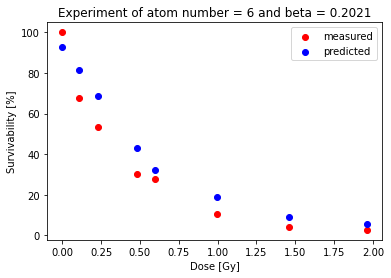

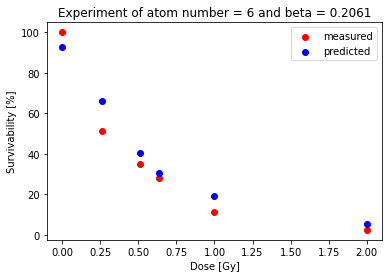

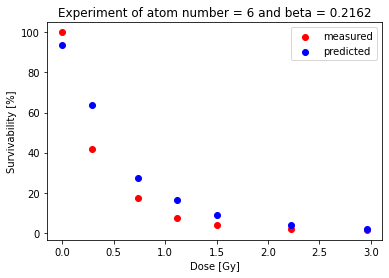

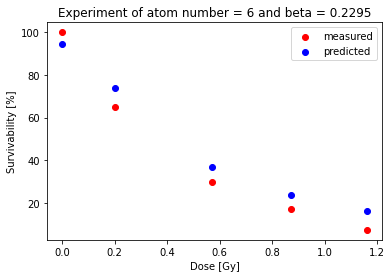

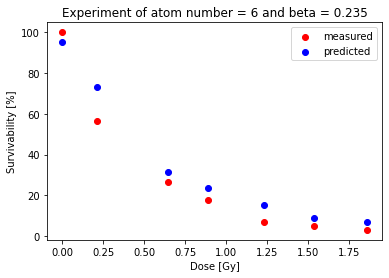

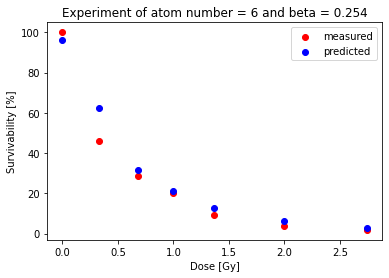

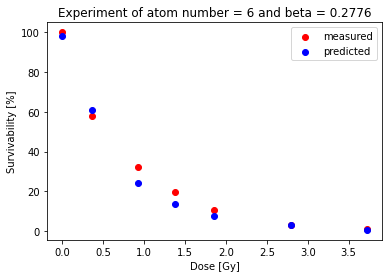

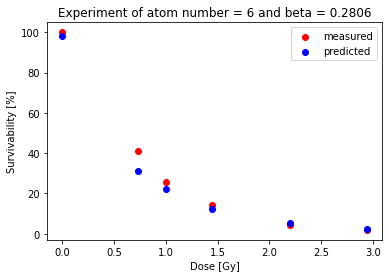

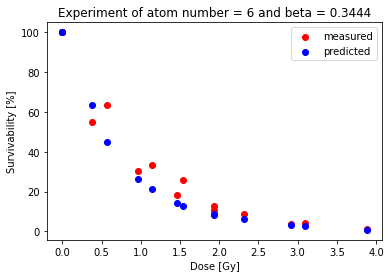

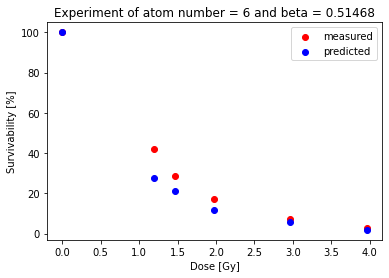

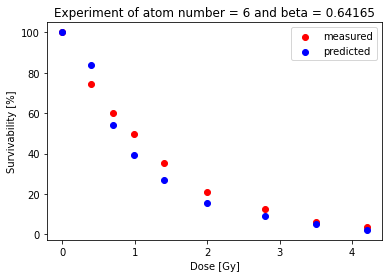

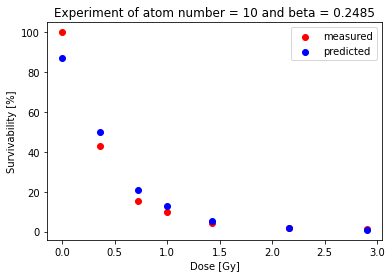

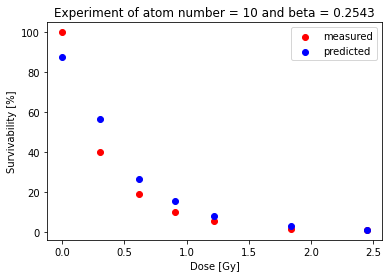

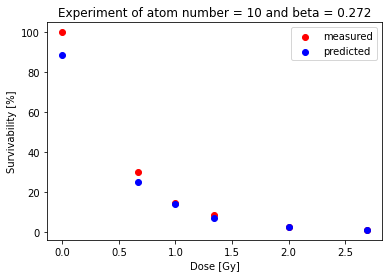

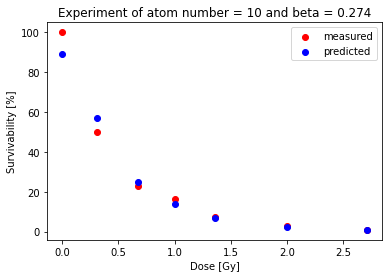

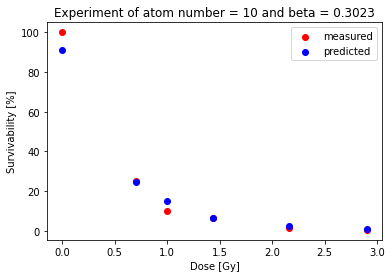

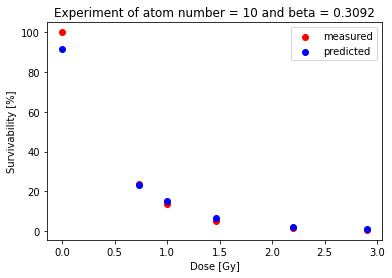

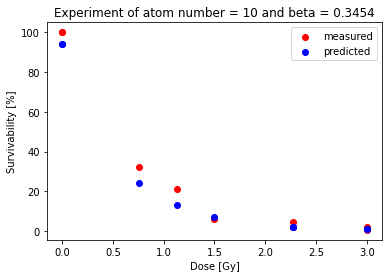

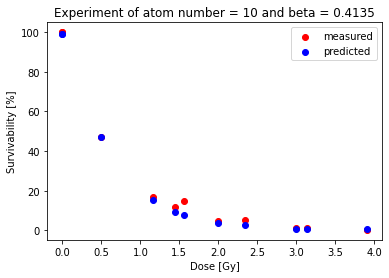

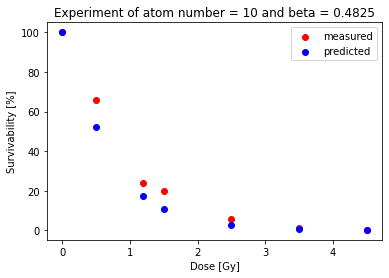

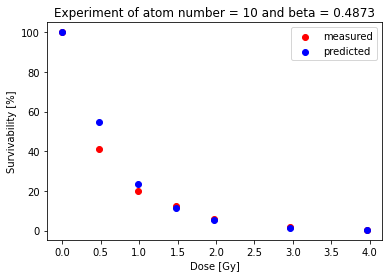

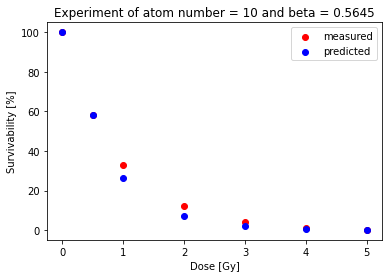

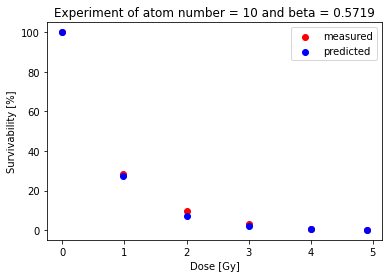

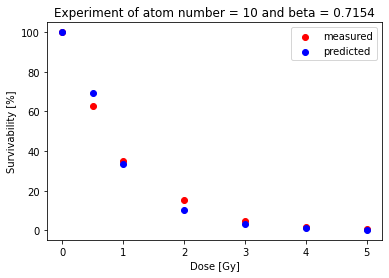

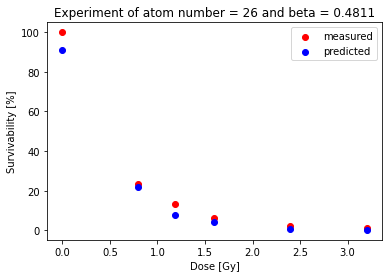

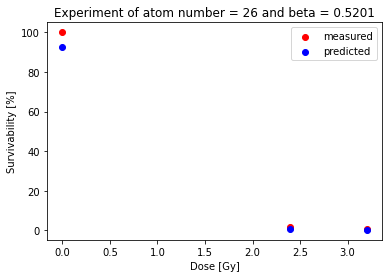

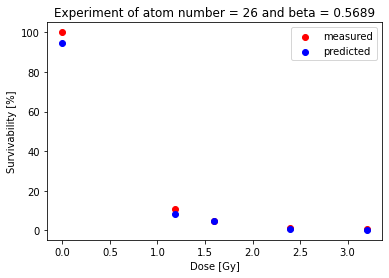

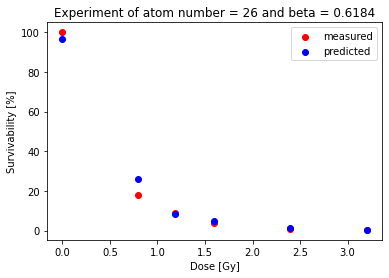

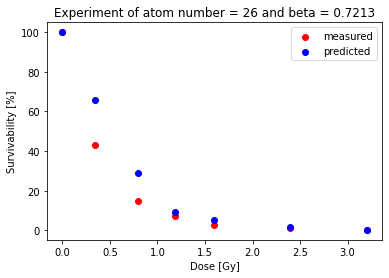

In [ ]:
plot_survivabilities_for_elements(analyses_result["X"], analyses_result["y"], analyses_result["y_pred"],
                                  'atom_number', 'beta', 'dose')